Observation shape: (1, 726)
Step 0:


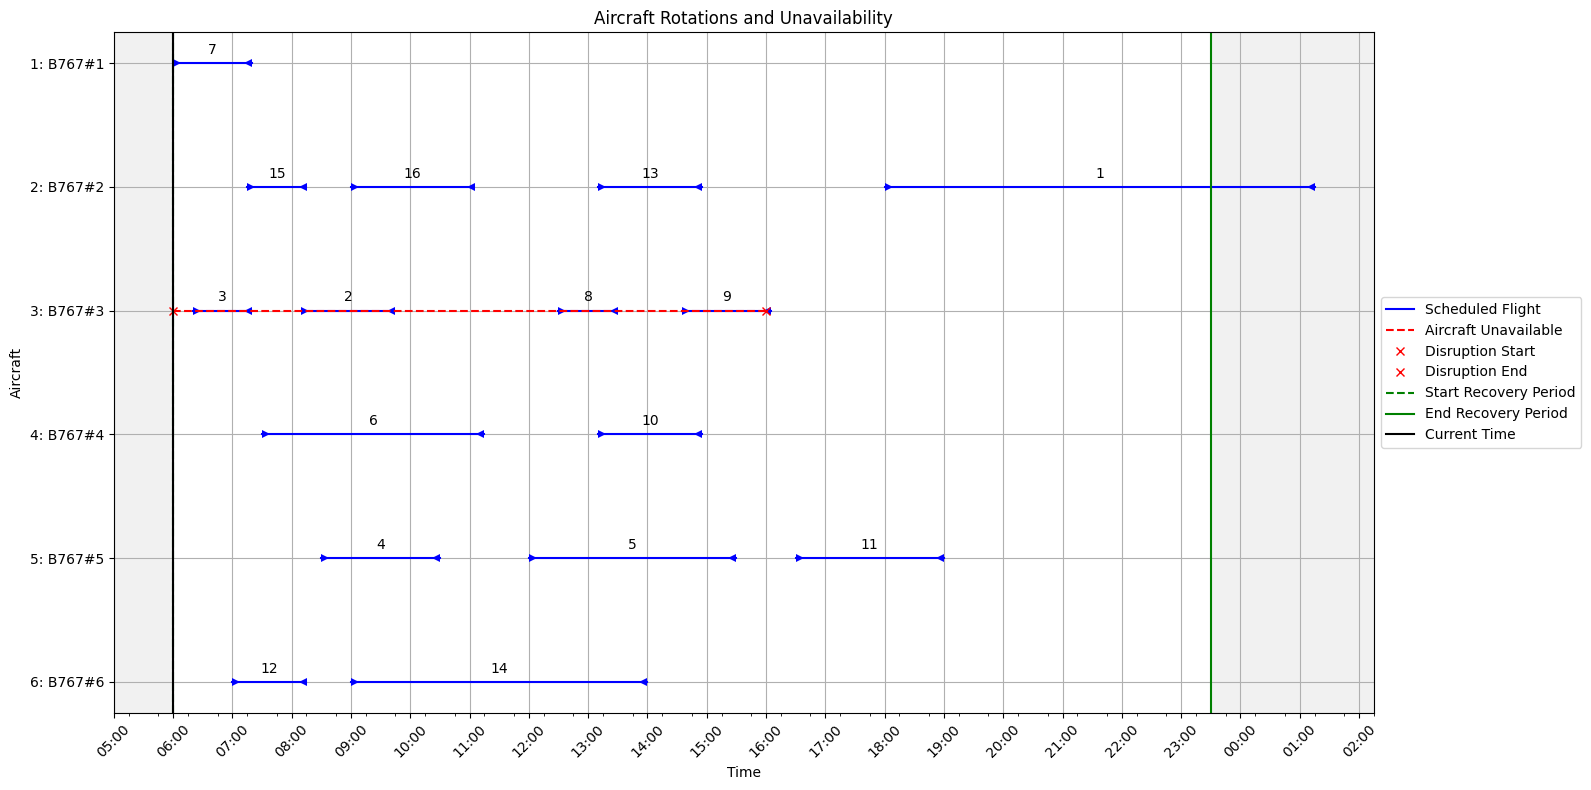

Chosen action: 5
  +1000 for resolving 1 conflicts
  -0 for delays (0 minutes)
  -0 penalty for cancelled flights
  -0 for inaction with conflicts
_______________
1000 total reward for action: 5

Step 1:


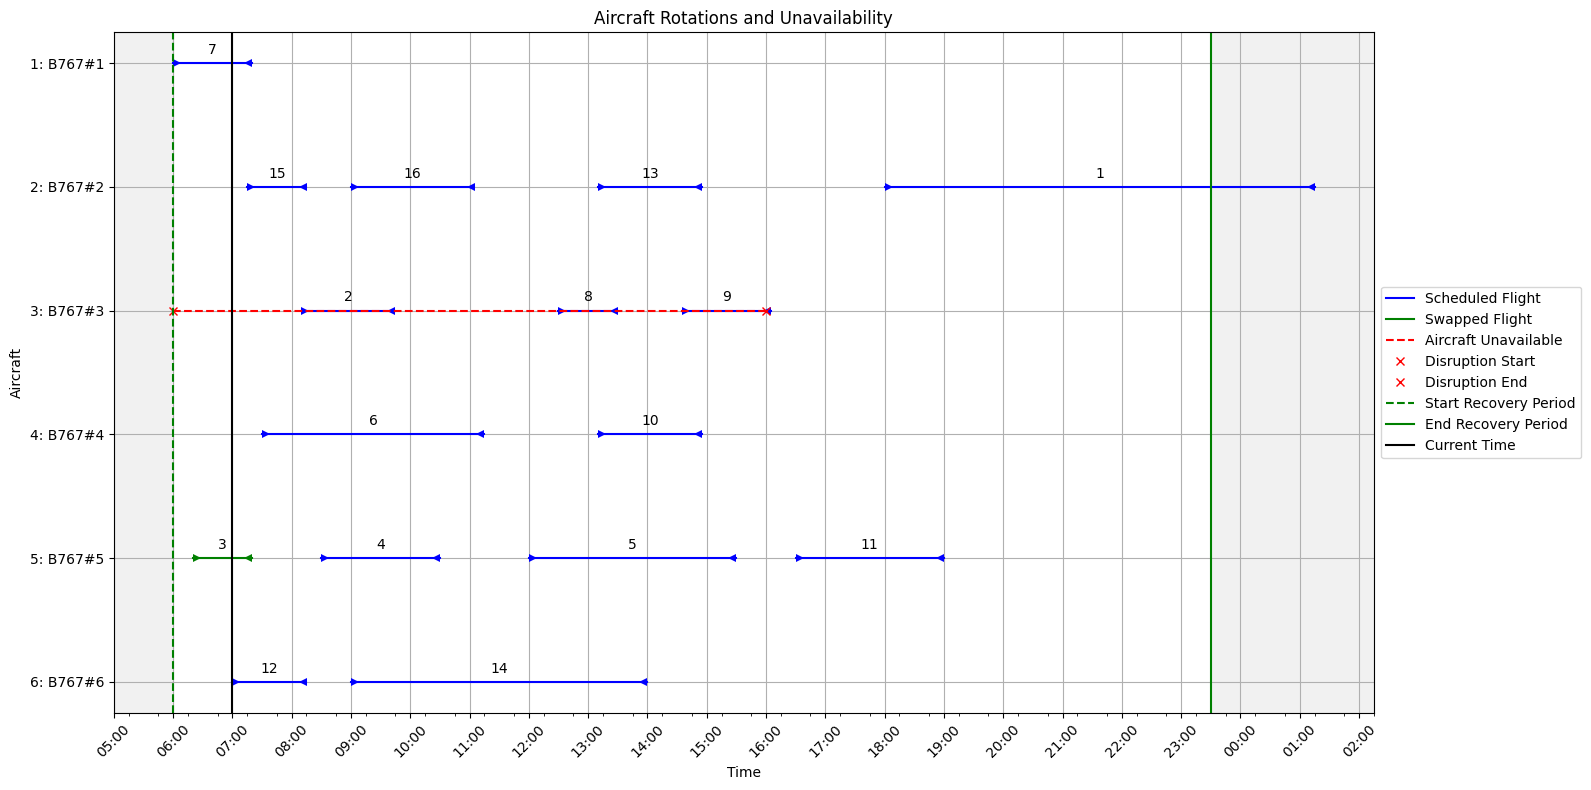

Chosen action: 4
  +1000 for resolving 1 conflicts
  -155.0 for delays (155.0 minutes)
  -0 penalty for cancelled flights
  -0 for inaction with conflicts
_______________
845.0 total reward for action: 4

Step 2:


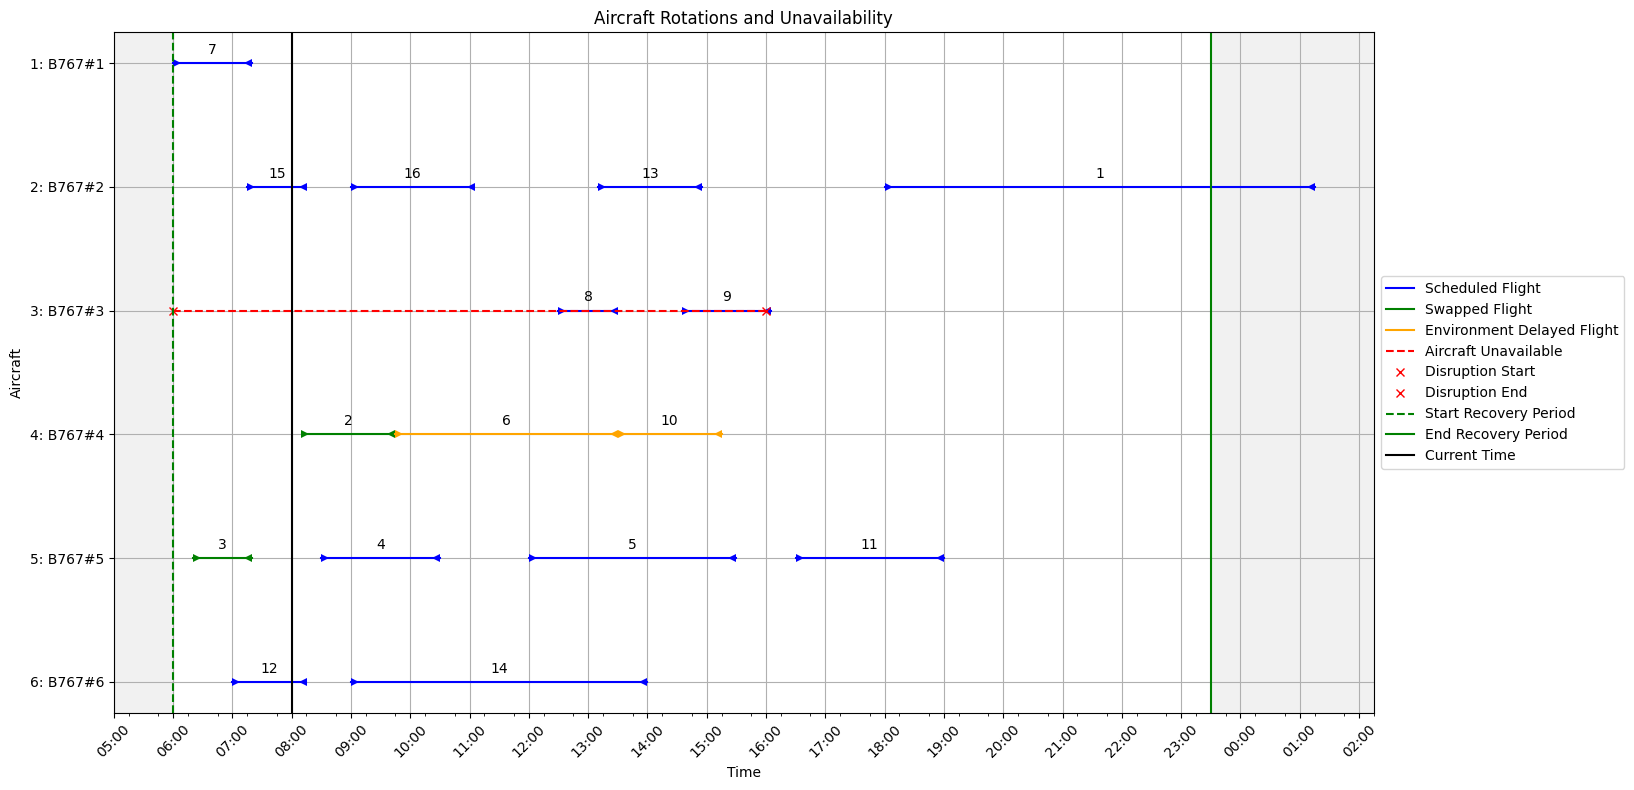

Chosen action: 0
  +0 for resolving 0 conflicts
  -0 for delays (0 minutes)
  -0 penalty for cancelled flights
  -5 for inaction with conflicts
_______________
-5 total reward for action: 0

Step 3:


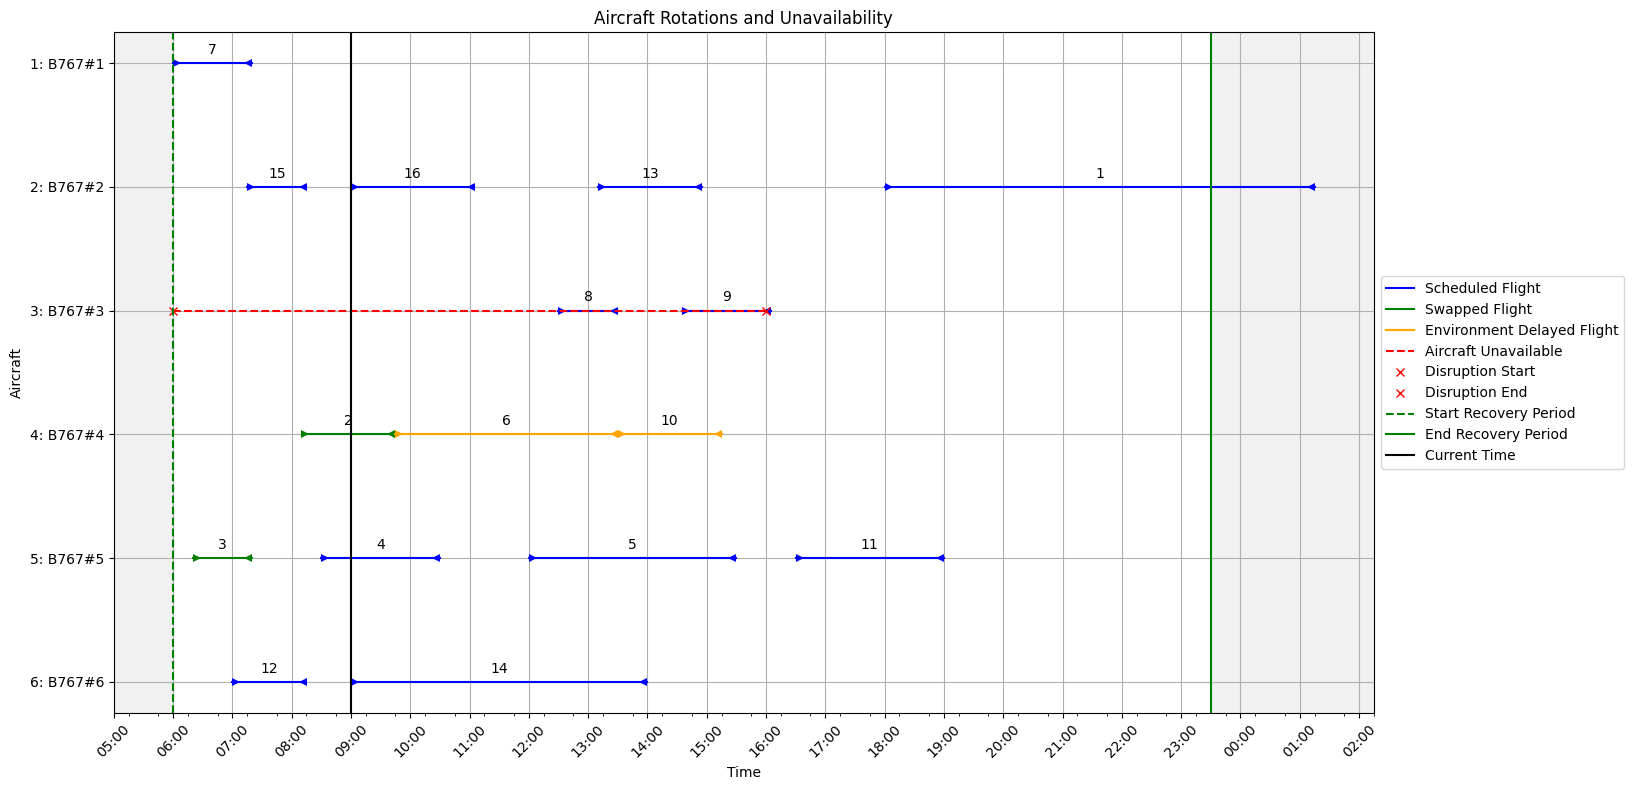

Chosen action: 4
  +1000 for resolving 1 conflicts
  -60.0 for delays (60.0 minutes)
  -0 penalty for cancelled flights
  -0 for inaction with conflicts
_______________
940.0 total reward for action: 4

Step 4:


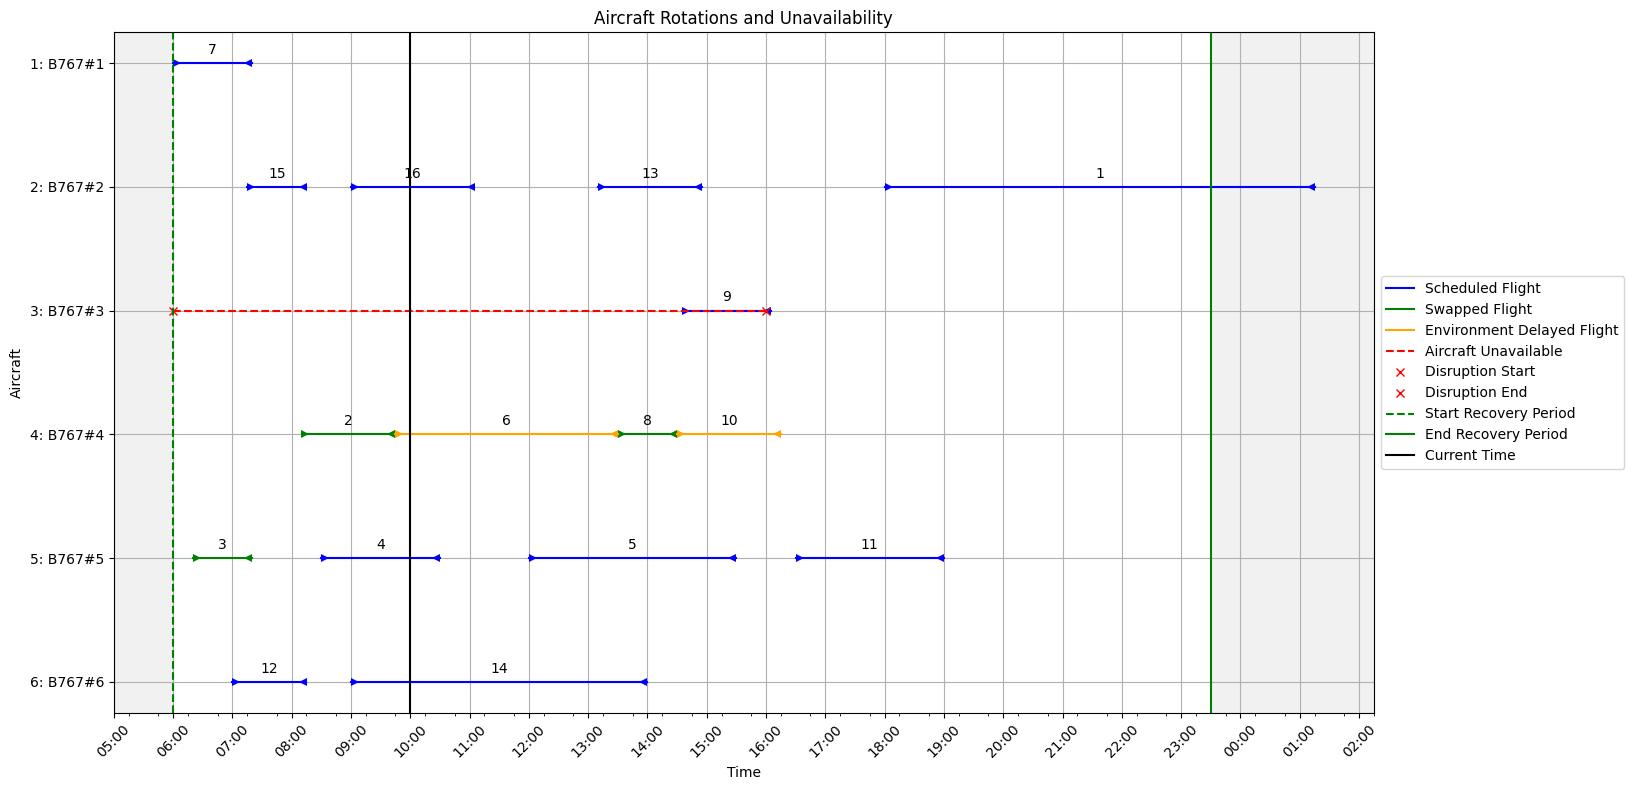

Chosen action: 2
  +1000 for resolving 1 conflicts
  -20.0 for delays (20.0 minutes)
  -0 penalty for cancelled flights
  -0 for inaction with conflicts
_______________
980.0 total reward for action: 2

Step 5:


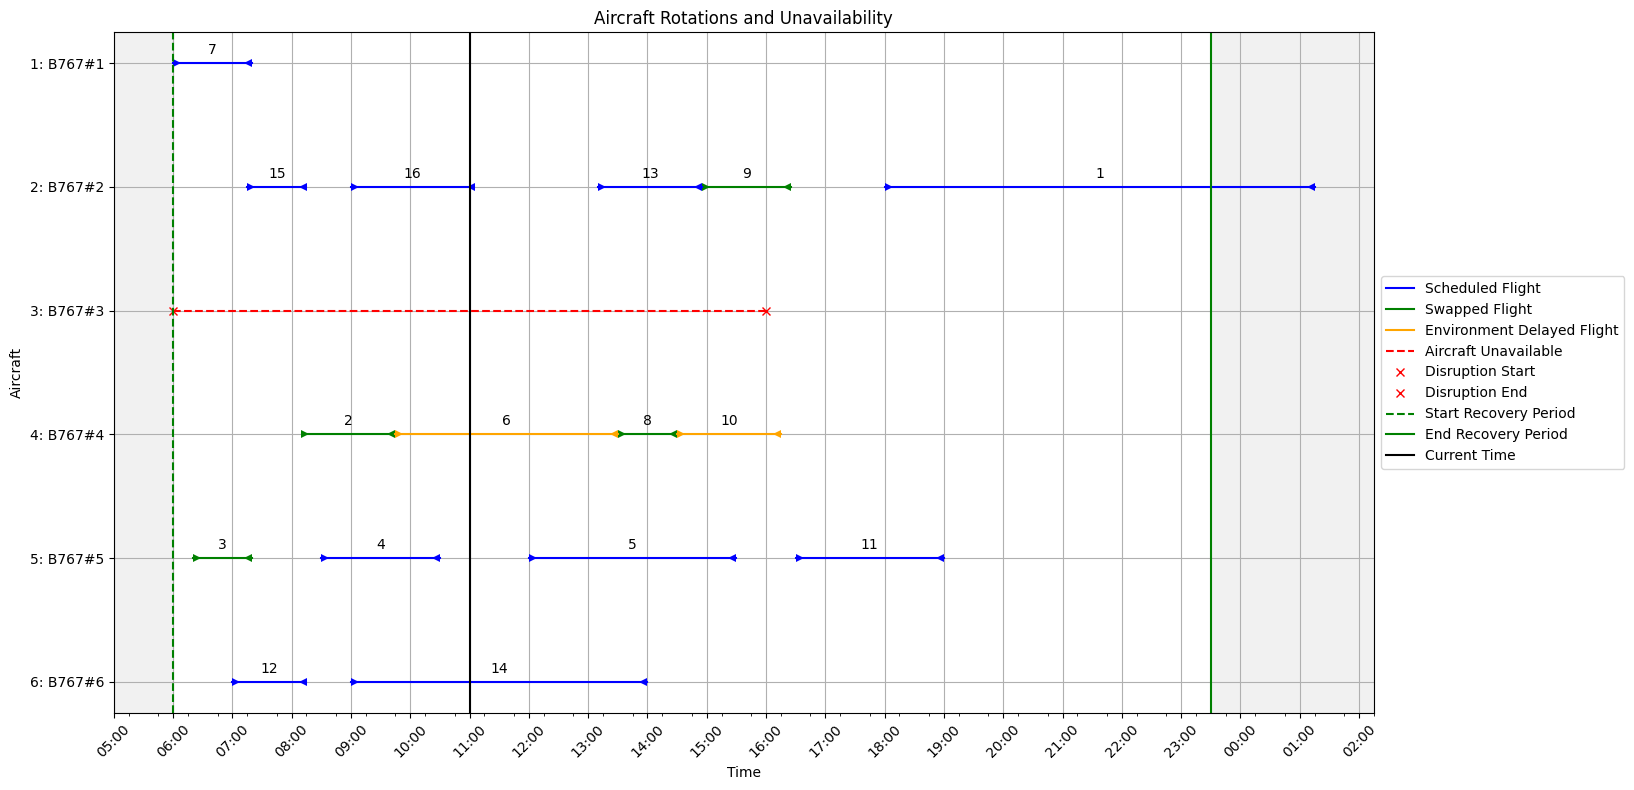


Total Reward: 3760.0


In [1]:
import os
import numpy as np
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter


# Run the random agent
def run_random_agent(scenario_folder):
    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)
    env = DummyVecEnv([lambda: env])

    # Reset the environment
    obs = env.reset()
    print("Observation shape:", obs.shape)

    done = False
    total_reward = 0
    step_num = 0

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=aircraft_dict,
        flights_dict=flights_dict,
        rotations_dict=rotations_dict,
        alt_aircraft_dict=alt_aircraft_dict,
        start_datetime=env.get_attr('start_datetime')[0],
        end_datetime=env.get_attr('end_datetime')[0]
    )

    while not done:
        # Visualize the environment at each step
        print(f"Step {step_num}:")

        # Extract necessary information from the environment for plotting
        swapped_flights = env.get_attr('swapped_flights')[0]
        environment_delayed_flights = env.get_attr('environment_delayed_flights')[0]
        current_datetime = env.get_attr('current_datetime')[0]

        # Retrieve the updated flights_dict from the environment
        updated_flights_dict = env.get_attr('flights_dict')[0]
        cancelled_flights = env.get_attr('penalized_cancelled_flights')[0]

        state_plotter.plot_state(updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime)
        
        # Sample a random action
        action = np.random.randint(0, env.action_space.n, size=env.num_envs)
        # action = [0]  # Always no action

        # Step the environment
        obs, reward, done, info = env.step(action)

        # Extract values from arrays
        reward = reward[0]
        done = done[0]

        # Accumulate the reward
        total_reward += reward

        # print(f"Action taken: {action}, Reward: {reward}")
        print("")

        step_num += 1

    print(f"Total Reward: {total_reward}")

# Specify the scenario folder you want to use
SCENARIO_FOLDER = "../data/Example/Busy-scenario"  # Path to your scenario

# Verify folder exists
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

# Run the random agent
run_random_agent(SCENARIO_FOLDER)
